# ***Dynamic Pricing for Urban Parking Lots***

## **Capstone Project - Summer Analytics 2025**


# **Made By :**
## **Saisha Verma**
## **Gmail : saishaverma0512@gmail.com**

# **Tables of Content**
1. Introduction
2. Problem Statement & Dataset Overview
3. Data Preparation
4. Real-time Simulation with Pathway
5. Baseline Linear Pricing Model
6. Demand-based Pricing Model
7. Competitive Pricing Model
8. Real-time Visualization
9. Model Explanation & Assumptions

# **Introduction**

This notebook demonstrates the development of a real-time dynamic pricing engine for urban parking lots, using live data simulation, feature engineering, and dynamic pricing strategies. The project uses only **Python (Pandas, Numpy), Pathway** for streaming, and **Bokeh** for visualization, as per the problem statement ([see images 1-4]).

# **Problem Statement & Dataset Overview**

**Goal :**

Create a real-time dynamic pricing system for 14 urban parking lots, using demand, queue length, traffic, vehicle type, and competition, with all logic built from scratch.

**Features in Dataset :**
> SystemCodeNumber: Parking lot identifier

> Capacity: Total parking spots

> Occupancy: Occupied spots

> QueueLength: Vehicles waiting

> Latitude, Longitude: Location

> VehicleType: car/bike/truck

>
> IsSpecialDay: 1 if special day, else 0

> TrafficConditionNearby: low/average/high

> Timestamp: Combined date and time

# **Data Preparation**

In [ ]:
# Importing
import pandas as pd
import numpy as np

# Loading Data
df = pd.read_csv('dataset.csv')

# Parsing Timestamps
df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], format='%d-%m-%Y %H:%M:%S')
df = df.sort_values(['SystemCodeNumber', 'Timestamp']).reset_index(drop=True)

# Exploring & Preprocessing
# -> Filling missing values if any
df = df.fillna(method='ffill')

# -> Encoding categorical variables
df['TrafficConditionNearby'] = df['TrafficConditionNearby'].map({'low': 0, 'average': 1, 'high': 2})
vehicle_type_map = {'car': 0, 'bike': 1, 'truck': 2, 'cycle': 3}
df['VehicleType'] = df['VehicleType'].map(vehicle_type_map)

# -> For simulation, select relevant columns
cols_for_stream = [
    "SystemCodeNumber", "Timestamp", "Capacity", "Occupancy", "QueueLength",
    "TrafficConditionNearby", "IsSpecialDay", "VehicleType", "Latitude", "Longitude"
]
df[cols_for_stream].to_csv("parking_stream_full.csv", index=False)
df.head()

# **Real-time Simulation with Pathway**

In [ ]:
# Installing pathway
!pip install pathway bokeh --quiet

In [ ]:
import pathway as pw

# 1. Define Pathway schema for streaming
class ParkingSchema(pw.Schema):
    SystemCodeNumber: str
    Timestamp: str
    Capacity: int
    Occupancy: int
    QueueLength: int
    TrafficConditionNearby: int
    IsSpecialDay: int
    VehicleType: int
    Latitude: float
    Longitude: float

# 2. Simulate the data stream
data = pw.demo.replay_csv("parking_stream_full.csv", schema=ParkingSchema, input_rate=1000)

# 3. Feature Engineering in Pathway
fmt = "%Y-%m-%d %H:%M:%S"
data_with_time = data.with_columns(
    t = data.Timestamp.dt.strptime(fmt),                       # parsed datetime
    day = data.Timestamp.dt.strptime(fmt).dt.strftime("%Y-%m-%dT00:00:00"),  # day for daily window
    occ_rate = data.Occupancy / data.Capacity,                 # occupancy rate 0-1
)

# **Baseline Linear Model Pricing**

## **Model :**

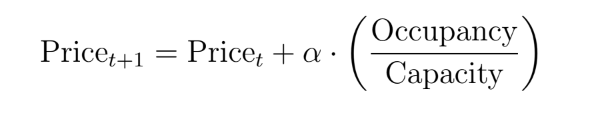

Implementing a **daily tumbling window** per parking lot.

In [ ]:
import datetime
import pathway as pw

BASE_PRICE = 10
ALPHA      = 2.0

baseline_window = (
    data_with_time.windowby(
        pw.this.t,
        instance=pw.this.SystemCodeNumber + "_" + pw.this.day,
        window=pw.temporal.tumbling(datetime.timedelta(days=1)),
        behavior=pw.temporal.exactly_once_behavior()
    )
    .reduce(
        lot          = pw.reducers.earliest(pw.this.SystemCodeNumber),
        t            = pw.this._pw_window_end,
        occ_max      = pw.reducers.max(pw.this.Occupancy),
        occ_min      = pw.reducers.min(pw.this.Occupancy),
        cap          = pw.reducers.max(pw.this.Capacity),
        occ_rate_max = pw.reducers.max(pw.this.occ_rate),
    )
    .with_columns(
        price = BASE_PRICE + ALPHA * pw.this.occ_rate_max
    )
)


# **Advanced Demand-Based Pricing Model**

## **Model :**

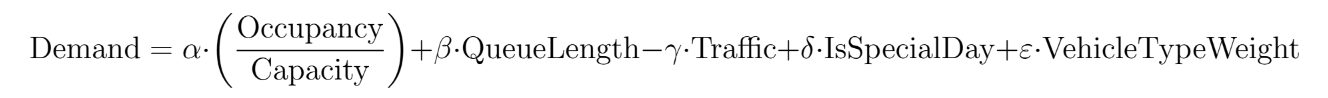

In [ ]:
# Coefficients for demand function
A = 2.0   # OccRate weight
B = 0.8   # QueueLength weight
C = 0.5   # Traffic weight
D = 2.0   # IsSpecialDay weight
E = 0.5   # VehicleType weight

# Assuming you already have 'data_with_time' table with these fields
data_with_demand = data_with_time.with_columns(
    demand = (
        A * pw.this.occ_rate +
        B * pw.this.QueueLength / 10 +
        C * pw.this.TrafficConditionNearby / 2 +
        D * pw.this.IsSpecialDay +
        E * pw.this.VehicleType / 3
    )
)

In [ ]:
import datetime
import pathway as pw

BASE_PRICE = 10
LAMBDA = 1.0

# Add demand score to your data (if not already done)
data_with_demand = data_with_time.with_columns(
    demand = (
        A * pw.this.occ_rate +
        B * pw.this.QueueLength / 10 +
        C * pw.this.TrafficConditionNearby / 2 +
        D * pw.this.IsSpecialDay +
        E * pw.this.VehicleType / 3
    )
)

# Create daily pricing window
demand_window = (
    data_with_demand.windowby(
        pw.this.t,
        instance=pw.this.SystemCodeNumber + "_" + pw.this.day,
        window=pw.temporal.tumbling(datetime.timedelta(days=1)),
        behavior=pw.temporal.exactly_once_behavior()
    )
    .reduce(
        lot          = pw.reducers.earliest(pw.this.SystemCodeNumber),
        t            = pw.this._pw_window_end,
        demand_max   = pw.reducers.max(pw.this.demand),
        demand_min   = pw.reducers.min(pw.this.demand),
        demand_sum   = pw.reducers.sum(pw.this.demand),
        demand_count = pw.reducers.count()
    )
    .with_columns(
        demand_avg = pw.this.demand_sum / pw.this.demand_count
    )
    .with_columns(
        norm_demand = pw.if_else(
            pw.this.demand_max - pw.this.demand_min > 0,
            (pw.this.demand_avg - pw.this.demand_min) / (pw.this.demand_max - pw.this.demand_min),
            0.0
        )
    )
    .with_columns(
        price = BASE_PRICE * (1 + LAMBDA * pw.this.norm_demand)
    )
)

# **Competitive Pricing Model**


**Logic :**

> For each lot, find the nearest other lot (by lat/long) and compare their price.

> If your lot is more expensive and less occupied, decrease price.

In [ ]:
from geopy.distance import geodesic
import json
import numpy as np

# Computing lot -> nearest_lot mapping using geopy
parking_lots = df[['SystemCodeNumber', 'Latitude', 'Longitude']].drop_duplicates().reset_index(drop=True)
lot_coords = parking_lots.set_index('SystemCodeNumber')[['Latitude', 'Longitude']].T.to_dict()

def find_nearest_lot(lot_id, lot_coords):
    latlon = (lot_coords[lot_id]['Latitude'], lot_coords[lot_id]['Longitude'])
    min_dist = float('inf')
    nearest = None
    for other, coord in lot_coords.items():
        if other == lot_id: continue
        dist = geodesic(latlon, (coord['Latitude'], coord['Longitude'])).meters
        if dist < min_dist:
            min_dist = dist
            nearest = other
    return nearest

nearest_mapping = {lot: find_nearest_lot(lot, lot_coords) for lot in lot_coords}

# UDF to fetch nearest lot from mapping
@pw.udf
def get_nearest_lot(lot_id: str) -> str:
    nearest_map = {
        # embed it statically (optional improvement: load externally if large)
        lot: find_nearest_lot(lot, lot_coords)
        for lot in lot_coords
    }
    return nearest_map.get(lot_id, None)

# UDF for reroute decision based on price
@pw.udf
def competitor_logic(price: float) -> str:
    competitor_price = BASE_PRICE + np.random.uniform(0, 2)  # Placeholder logic
    return "Suggest reroute" if price > competitor_price + 1 else "OK"

# Adding new columns using UDFs
demand_window = demand_window.with_columns(
    nearest_lot=get_nearest_lot(pw.this.lot)
)

demand_window = demand_window.with_columns(
    competitor_suggestion=competitor_logic(pw.this.price)
)


# **Real-Time Visualization (Bokeh & Panel)**

In [ ]:
import bokeh.plotting
import panel as pn

pn.extension()

def price_plotter(source):
    fig = bokeh.plotting.figure(
        height=400,
        width=800,
        title="Daily Parking Price (Demand-Based Model)",
        x_axis_type="datetime"
    )
    fig.line("t", "price", source=source, line_width=2, color="navy", legend_label="Our Price")
    fig.circle("t", "price", source=source, size=6, color="red")
    # Optionally plot competitor prices or demand
    # fig.line("t", "competitor_price", source=source, line_width=2, color="orange", legend_label="Competitor")
    fig.legend.location = "top_left"
    return fig

# Visualize for any one lot, e.g., "BHMBCCMKT01"
selected_lot = "BHMBCCMKT01"
viz = (
    demand_window.filter(pw.this.lot == selected_lot)
    .plot(price_plotter, sorting_col="t")
)

pn.Column(viz).servable()

In [ ]:
# To visualize real-time run this cell
%%capture --no-display
pw.run()

# **Model Explanation & Assumptions**

## **Model 1 (Baseline) :**

> Price increases linearly with occupancy rate.

> Good as a reference, but reacts only to one feature.

## **Model 2 (Demand-Based) :**

> Considers queue, traffic, vehicle type, special days.

> Demand is normalized and bounded, keeping price smooth.

**Assumptions :**
> All features contribute linearly (feel free to use nonlinear if desired).

> Coefficients are chosen based on feature scale and intuition.


## **Model 3 (Competitive) :**

> Tries to detect if nearby lots are cheaper.

> Can suggest rerouting or lowering the price if outcompeted.

# **Thank you :)**

